In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
from PIL import Image

In [3]:
def get_image_size(file_path):
    try:
        # Open the image file
        with Image.open(file_path) as img:
            # Get the dimensions of the image
            width, height = img.size
            return width, height
    except Exception as e:
        print(f"Error: {e}")
        return None, None

def list_files_with_size(root_folder):
    # Create an empty list to store file information
    file_info = []

    # Traverse through the root folder and its subfolders
    for folder, _, files in os.walk(root_folder):
        for filename in files:
            # Construct the full path of the file
            file_path = os.path.join(folder, filename)

            # Get the size of the file in bytes
            file_size = os.path.getsize(file_path)

            # Extract the label (subfolder name)
            label = os.path.basename(folder)

            # Get the dimensions of the image
            width, height = get_image_size(file_path)

            # Append file information to the list
            file_info.append((filename, label, file_path, file_size, width, height))

    return file_info

In [5]:
root_folder = '/content/drive/MyDrive/Fruit_classification/train/train'
files_info = list_files_with_size(root_folder)
# Create a DataFrame from the list of file information
df_trainset = pd.DataFrame(files_info, columns=['Filename', 'Label', 'Path', 'Size', 'Width', 'Height'])

In [6]:
df_trainset.head()

,Filename,Label,Path,Size,Width,Height
0,Raspberry_131.jpg,Raspberry,/content/drive/MyDrive/Fruit_classification/tr...,6889,100,100
1,Raspberry_334.jpg,Raspberry,/content/drive/MyDrive/Fruit_classification/tr...,6847,100,100
2,Raspberry_333.jpg,Raspberry,/content/drive/MyDrive/Fruit_classification/tr...,6199,100,100
3,Raspberry_301.jpg,Raspberry,/content/drive/MyDrive/Fruit_classification/tr...,7274,100,100
4,Raspberry_295.jpg,Raspberry,/content/drive/MyDrive/Fruit_classification/tr...,6142,100,100


In [7]:
print(df_trainset.shape)
print(df_trainset.Width.unique())
print(df_trainset.Height.unique())

(16918, 6)
[100]
[100]


In [8]:
root_folder = '/content/drive/MyDrive/Fruit_classification/test/test'
files_info = list_files_with_size(root_folder)
# Create a DataFrame from the list of file information
df_testset = pd.DataFrame(files_info, columns=['Filename', 'Label', 'Path', 'Size', 'Width', 'Height'])

In [9]:
df_testset.head()

,Filename,Label,Path,Size,Width,Height
0,5370.jpg,test,/content/drive/MyDrive/Fruit_classification/te...,4644,100,100
1,4876.jpg,test,/content/drive/MyDrive/Fruit_classification/te...,6104,100,100
2,4929.jpg,test,/content/drive/MyDrive/Fruit_classification/te...,3911,100,100
3,4865.jpg,test,/content/drive/MyDrive/Fruit_classification/te...,4874,100,100
4,5182.jpg,test,/content/drive/MyDrive/Fruit_classification/te...,5185,100,100


In [10]:
print(df_testset.shape)
print(df_testset.Width.unique())
print(df_testset.Height.unique())

(5644, 6)
[100]
[100]


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import joblib

# Load the dataset
df = df_trainset  # Update with the actual path to the dataset file

# Data preprocessing
# Perform any necessary preprocessing steps such as resizing, normalization, and augmentation
# For example:
# - Resize images to a uniform size
# - Normalize pixel values
# - Augment the data to increase diversity

# Split the dataset into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Create image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size and image size
batch_size = 32
image_size = (100, 100)  # Update with the desired image size

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Path',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='Path',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Path',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model creation
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_df['Label'].unique()), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the label_encoder
label_encoder = train_generator.class_indices
joblib.dump(label_encoder, "label_encoder.pkl")


Found 10827 validated image filenames belonging to 33 classes.
Found 2707 validated image filenames belonging to 33 classes.
Found 3384 validated image filenames belonging to 33 classes.
Epoch 1/20
339/339 [==============================] - 92s 252ms/step - loss: 1.3035 - accuracy: 0.5834 - val_loss: 0.2276 - val_accuracy: 0.9254
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


339/339 [==============================] - 100s 294ms/step - loss: 0.3337 - accuracy: 0.8839 - val_loss: 0.0980 - val_accuracy: 0.9756
Epoch 3/20
339/339 [==============================] - 106s 312ms/step - loss: 0.2197 - accuracy: 0.9251 - val_loss: 0.0279 - val_accuracy: 0.9919
Epoch 4/20
339/339 [==============================] - 98s 290ms/step - loss: 0.1674 - accuracy: 0.9417 - val_loss: 0.0554 - val_accuracy: 0.9756
Epoch 5/20
339/339 [==============================] - 85s 252ms/step - loss: 0.1213 - accuracy: 0.9595 - val_loss: 0.0079 - val_accuracy: 0.9993
Epoch 6/20
339/339 [==============================] - 93s 273ms/step - loss: 0.1291 - accuracy: 0.9575 - val_loss: 0.0096 - val_accuracy: 0.9978
Epoch 7/20
339/339 [==============================] - 97s 286ms/step - loss: 0.1088 - accuracy: 0.9646 - val_loss: 0.0169 - val_accuracy: 0.9919
Epoch 8/20
339/339 [==============================] - 101s 298ms/step - loss: 0.1057 - accuracy: 0.9662 - val_loss: 0.0084 - val_accuracy: 

['label_encoder.pkl']

In [12]:
import joblib
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from random import sample
from tensorflow.keras.models import load_model

# Load the test set DataFrame
test_df = df_testset

# Load the label encoder
label_encoder = joblib.load("label_encoder.pkl")  # Load the label encoder saved during training
label_encoder_inverse = {value: key for key, value in label_encoder.items()}
model = load_model("best_model.h5")
# Function to preprocess an image from its file path
def preprocess_image(img_path, target_size=(100, 100)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Make predictions for all images in the test set
predictions = []
for img_path in test_df['Path']:
    preprocessed_img = preprocess_image(img_path)
    preprocessed_img = preprocessed_img.reshape(1, *preprocessed_img.shape)  # Reshape for model prediction
    prediction = model.predict(preprocessed_img)
    predicted_class = label_encoder_inverse[prediction.argmax()]
    predictions.append(predicted_class)

# Add predictions to the test set DataFrame
test_df['Predicted_Label'] = predictions

# Display the updated DataFrame with predictions
print(test_df.head())


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
   Filename Label                                               Path  Size  \
0  5370.jpg  test  /content/drive/MyDrive/Fruit_classification/te...  4644   
1  4876.jpg  test  /content/drive/MyDrive/Fruit_classification/te...  6104   
2  4929.jpg  test  /content/drive/MyDrive/Fruit_classification/te...  3911   
3  4865.jpg  test  /content/drive/MyDrive/Fruit_classification/te...  4874   
4  5182.jpg  test  /content/drive/MyDrive/Fruit_classification/te...  5185   

   Width  Height Predicted_Label  
0    100     100          Tomato  
1    100     100     Onion White  
2    100     100       Blueberry  
3    100     100      Pepper Red  
4    100     100            Kiwi  


In [13]:
test_df.drop(columns=['Label', 'Path', 'Size', 'Width', 'Height']).to_csv('Fruit_Classification_result.csv')

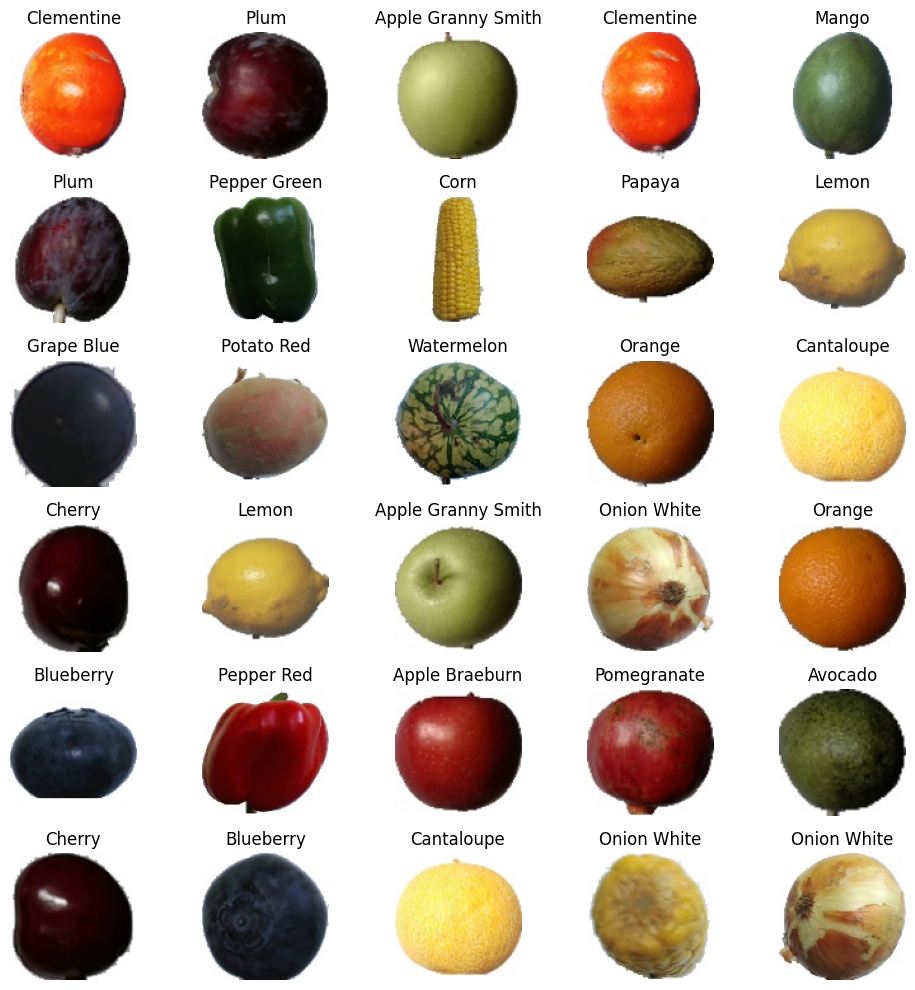

In [14]:
# Display randomly chosen 30 images along with their inference results
random_indices = sample(range(len(test_df)), 30)
fig, axes = plt.subplots(6, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    img_path = test_df.iloc[idx]['Path']
    inference_result = test_df.iloc[idx]['Predicted_Label']
    img = image.load_img(img_path, target_size=(100, 100))
    ax.imshow(img)
    ax.set_title(f"{inference_result}")
    ax.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 57ms/step


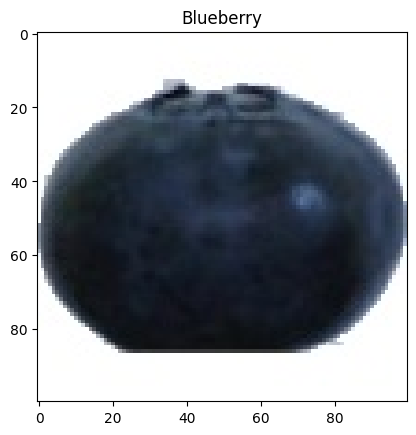

In [15]:
# Load any image_path for visual verification
img_path = df_testset.Path[2]
preprocessed_img = preprocess_image(img_path)
preprocessed_img = preprocessed_img.reshape(1, *preprocessed_img.shape)  # Reshape for model prediction
prediction = model.predict(preprocessed_img)
predicted_class = label_encoder_inverse[prediction.argmax()]
img = plt.imread(img_path)
plt.imshow(img)
plt.title(predicted_class)
plt.show()